# Common imports

In [1]:
%matplotlib inline
import os
import sys
import glob
import re
import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

# Provided functions
### Image loading and saving

In [2]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [3]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

### Plot the height map

In [4]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


def display_output(albedo_image, height_map):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(20, 20)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

def display_output_custom(albedo_image, height_map, el=20, az=20, X=0, Y=1, Z=2):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(el, az)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

### Plot the surface norms. 

In [5]:
def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0])
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1])
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2])

# Your implementation

In [6]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    h,w,N = imarray.shape
    processed_imarray = np.zeros(imarray.shape)
    for i in range(N):
        processed_imarray[:,:,i] = imarray[:,:,i] - ambimage[:,:]
    processed_imarray.clip(0,255)
    processed_imarray = processed_imarray / 255.0
    return processed_imarray

In [7]:
def svdInv(A):
    U, sigma, Vt = la.svd(A, full_matrices=False)
    for i in range(len(sigma)):
        if sigma[i] <= 0.001:
            sigma[i] = 10**20
    Sigma_pseuinv = np.diag(1/ sigma)
    Sigma_pseuinv = Sigma_pseuinv.round(10)
    return U.T, Sigma_pseuinv, Vt.T
def lstsq(Ut, sigmaInv, V, b):  
    x_hat = V.dot(sigmaInv).dot(Ut).dot(b)
    x_hat = x_hat.flatten()
    return x_hat
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    #assume k = 1?
    #I = Vg solve for g
    #I = [pixel value of every source]  nx1
    #V = [light direction of every source]  nx3
    #g = vector of direction 3x1
    Ut, sigmaInv, V = svdInv(light_dirs)
    h,w,N = imarray.shape
    g = np.zeros((h,w,3))
    albedo_image = np.zeros((h,w))
    surface_normals = np.zeros((h,w,3))
    for i in range(h):
        for j in range(w):
            I = imarray[i,j,:]
            I = I.reshape((N,1))
            g[i,j,:] = lstsq(Ut, sigmaInv, V, I)

            albedo_image[i,j] = la.norm(g[i,j,:])
            surface_normals[i,j,:] = g[i,j,:] / albedo_image[i,j]
    return albedo_image, surface_normals

In [17]:
import random
def intg_r(d, h, w, fy):
    c = fx[h,:].cumsum().reshape(1,w)
    fyr = np.copy(fy)
    fyr[0,:] = 0.5 * fyr[0,:] + 0.5 * row0
    height_map = fyr.cumsum(axis=0)
    return height
def integ_c(r, x, fy):
    height = C
    for i in range(r+1):
        height += fy[x,i]
    return height
    
def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    h,w,r = surface_normals.shape
    height_map = np.zeros((h,w))
    fx = surface_normals[:,:,0] / surface_normals[:,:,2]
    fy = surface_normals[:,:,1] / surface_normals[:,:,2]
    if integration_method == 'column':
        col0 = fy[:,0].cumsum()
        fxc = np.copy(fx)
        fxc[:,0] =  0.5 * fxc[:,0] + 0.5 *col0
        height_map = fxc.cumsum(axis=1)
    
    
    if integration_method == 'row':
        row0 = fx[0,:].cumsum().reshape(1,w)
        fyr = np.copy(fy)
        fyr[0,:] = 0.5 * fyr[0,:] + 0.5 * row0
        height_map = fyr.cumsum(axis=0)
        print(height_map.shape)
    
    
    if integration_method == "average":
        col0 = fy[:,0].cumsum()
        fxc = np.copy(fx)
        fxc[:,0] =  0.5 * fxc[:,0] + 0.5 *col0
        height_map_c = fxc.cumsum(axis=1)
        
        row0 = fx[0,:].cumsum().reshape(1,w)
        fyr = np.copy(fy)
        fyr[0,:] = 0.5 * fyr[0,:] + 0.5 * row0
        height_map_r = fyr.cumsum(axis=0)
        
        height_map = height_map_c * 0.5 + height_map_r * 0.5
        
    if integration_method == "random":
        for i in range(h):
            for j in range(w):
                heights = []
                for p in range(int(min(i,j)) + 1):
                    randHeight = random.randint(0, i)
                    randWidth =  random.randint(0, j)
                    pivot = np.array([randHeight, randWidth])
                    height = 0.0
                    height += fy[:pivot[0], 0].sum()
                    height += fx[pivot[0], :pivot[1]].sum()
                    height += fy[pivot[0]:i, pivot[1]].sum()
                    height += fx[i, pivot[1]:j].sum()
                    heights.append(height)
                    
                    height = 0.0
                    height += fx[0, pivot[1]].sum()
                    height += fy[:pivot[0], pivot[1]].sum()
                    height += fx[pivot[0], pivot[1]:j].sum()
                    height += fy[pivot[0]:i, j].sum()
                    heights.append(height)
                height_map[i,j] = np.mean(heights)
        
        
        
    
    return height_map


# Main function

In [23]:
root_path = 'croppedyale/'
subject_name = 'yaleB05'
integration_method = 'column'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)

processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                   light_dirs)
height_map = get_surface(surface_normals, integration_method)
if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

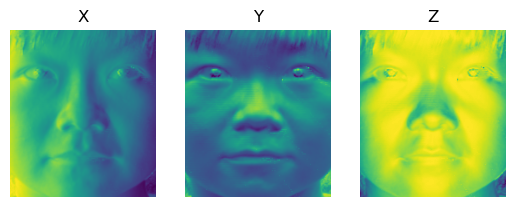

In [24]:
plot_surface_normals(surface_normals)
#15 70
#60 30
#15 30

C:\Users\fiona\AppData\Local\Temp\ipykernel_6188\3752925681.py:51: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


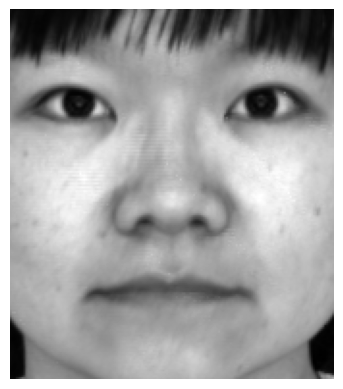

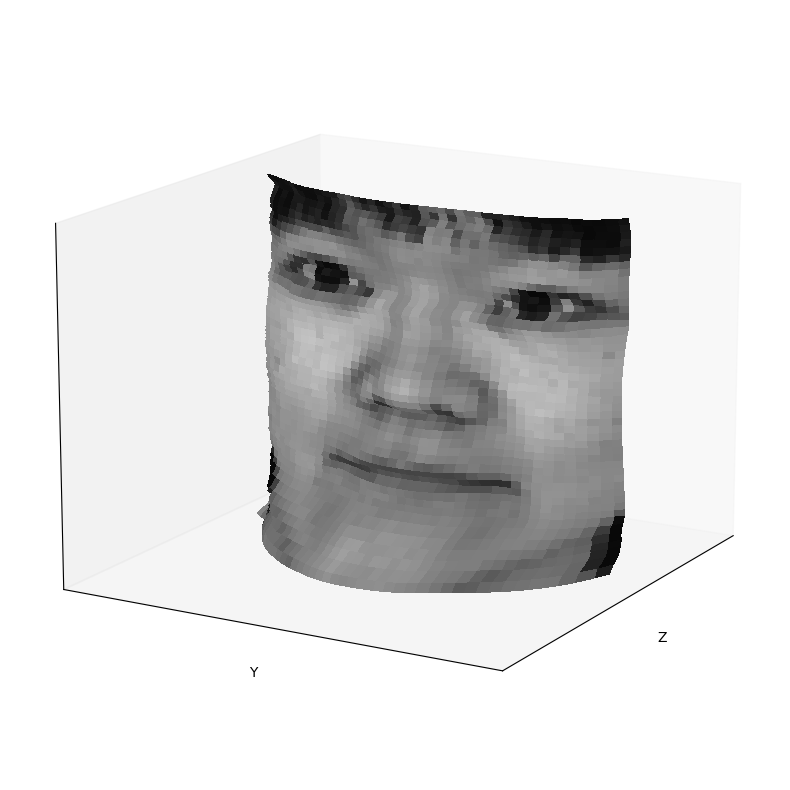

In [25]:

display_output_custom(albedo_image, height_map, el=15,az=30)

 ## EXTRA CREDIT

In [26]:
def load_custom(pathname, subject_name, num_images):
    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        unity_name = os.path.basename(fname)
        _, az = unity_name.split('az')
        az, el = az.split('el')
        el = el[:-4]
        return float(az), float(el)

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '.png'))
    ambimage = np.sum(ambimage,axis=2) / 3.0
    im_list = glob.glob(os.path.join(pathname, '*.png'))
    im_list = im_list[:-1]
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    h,w,c,N = imarray.shape
    grayArray = np.zeros((h,w,N))
    for i in range(N):
        grayArray[:,:,i] = np.sum(imarray[:,:,:,i],axis=2) / 3.0
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, grayArray, lightdirs
root_path = '../croppedyale/'
subject_name = 'unity'

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarrays, lightdirs = load_custom(full_path, subject_name,
                                                    60)
print(lightdirs[5])
print(imarrays.shape)
plt.imshow(imarrays[:,:,5], cmap='gray')

FileNotFoundError: [Errno 2] No such file or directory: '../croppedyale/unity\\unity.png'

In [ ]:
root_path = '../croppedyale/'
subject_name = 'unity'
integration_method = 'random'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = load_custom(full_path, subject_name,
                                                    60)

processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                   light_dirs)


surface_normals_fixed = np.copy(surface_normals)
surface_normals_fixed[:,:,0] = surface_normals[:,:,2]
surface_normals_fixed[:,:,1] = surface_normals[:,:,0]
surface_normals_fixed[:,:,2] = surface_normals[:,:,1]
surface_normals = surface_normals_fixed
height_map = get_surface(surface_normals, integration_method)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

In [ ]:
plot_surface_normals(surface_normals)

In [ ]:
display_output_custom(albedo_image, height_map, el=30,az=20)

In [ ]:
### problem(8)

In [ ]:
root_path = '../croppedyale/'
subject_name = 'yaleB01'
integration_method = 'random'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)
imarr1 = imarray[:,:,1:20]
imarr2 = imarray[:,:,35:47]
light_dirs1 = light_dirs[1:20,:]
light_dirs2 = light_dirs[35:47,:]
light_dirs = np.concatenate((light_dirs1, light_dirs2), axis=0)
imarray = np.concatenate((imarr1, imarr2), axis=2)
processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                   light_dirs)
height_map = get_surface(surface_normals, integration_method)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)



In [ ]:
plot_surface_normals(surface_normals)

In [ ]:
display_output_custom(albedo_image, height_map, el=15,az=70)

In [ ]:
root_path = '../croppedyale/'
subject_name = 'yaleB01'
integration_method = 'row'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)
plt.imshow(imarray[:,:,15], cmap='gray')